(logit:title)=
# Logistic Regression

The logistic regression model is trained with the following minimization problem:

$$
\min ~-\sum\limits_{i=1}^n\big(y_i \log(p_i(\pmb{w}, b)) + (1-y_i)\log(1 - p_i(\pmb{w}, b))\big) + \frac{1}{C}r(\pmb{w}) \tag{1}
$$

where the logistic function $p_i(\pmb{w}, b)$ is written as

$$
p_i = \frac{1}{1+\exp\left(- \pmb{x}_i^{\top}\pmb{w} - b\right)},
$$

and the function $r(\pmb{w})$ represents the shrinkage term that can be

- $l_1$ regularization: $r(\pmb{w}) = \|\pmb{w}\|_1$;
- $l_2$ regularization: $r(\pmb{w}) = \frac{1}{2}\|\pmb{w}\|_2^2$;
- No regularization: $r(\pmb{w}) = 0$.

The minimization problem $(1)$ is equivalent to the following constrained conic optimization problem

$$
\begin{align}
\min ~&-\sum\limits_{i=1}^n\left(y_i u_i + (1-y_i)v_i \right) + \frac{1}{C}r(\pmb{w}) \tag{2}\\
\text{s.t.}~&u_i \geq \log\left(1 + \exp\left(-\pmb{x}_i^{\top}\pmb{w} - b\right)\right) &\forall i = 1, 2, ..., n \tag{3}\\
&v_i \geq \log\left(1 + \exp\left(\pmb{x}_i^{\top}\pmb{w} + b\right)\right) &\forall i = 1, 2, ..., n \tag{4}
\end{align}
$$

where the softplus function $\log(1+\exp(\cdot))$ can be directly imported from the RSOME package. The code segment below defines the logistic regression model as a function named `logit()`, where the user can specify the type of the regularization term using the parameter `penalty`.

In [1]:
from rsome import ro
from rsome import msk_solver as msk
import rsome as rso

def logit(x, y, penalty='l2', C=1):
    
    n, m = x.shape
    
    model = ro.Model()

    b = model.dvar()
    w = model.dvar(m)
    u = model.dvar(n)
    v = model.dvar(n)
    
    if penalty is None:
        r = 0
    elif penalty == 'l1':
        r = rso.norm(w, 1)
    elif penalty == 'l2':
        r = 0.5*rso.sumsqr(w)
    else:
        raise ValueError('Unknown penalty term.')
    
    model.min(y@u + (1-y)@v + (1/C)*r)
    model.st(u >= rso.softplus(-x@w - b))
    model.st(v >= rso.softplus(x@w + b))

    model.solve(msk, display=False,
                params={'intpntCoTolRelGap': 1e-7})
    
    return b.get(), w.get()

Here, we use the Iris dataset imported from the scikit-learn package to test the performance of the `logit()` function. 

In [2]:
from sklearn import datasets

iris = datasets.load_iris()
x = iris.data
y = iris.target

x = x[y != 2]
y = y[y != 2]

x /= x.max()

The code segment below is used to run the `logit()` function with $l_1$ and $l_2$ regularizations while varying the shrinkage parameter `C`.

In [3]:
import pandas as pd
import numpy as np
from sklearn.svm import l1_min_c

cs = l1_min_c(x, y, loss="log") * np.logspace(0, 10, 16)

path_l1 = pd.DataFrame([])
for C in cs:
    b, w = logit(x, y, 'l1', C)
    path_l1[np.log10(C)] = w
path_l1.index = [f'Feature{i}' for i in range(x.shape[1])]

path_l2 = pd.DataFrame([])
for C in cs:
    b, w = logit(x, y, 'l2', C)
    path_l2[np.log10(C)] = w
path_l2.index = [f'Feature{i}' for i in range(x.shape[1])]

The regularization paths of the $l_1$ and $l_2$ cases are visualized below. Please refer to the results provided at [Regularization path of L1- Logistic Regression](https://scikit-learn.org/stable/auto_examples/linear_model/plot_logistic_path.html#sphx-glr-auto-examples-linear-model-plot-logistic-path-py).

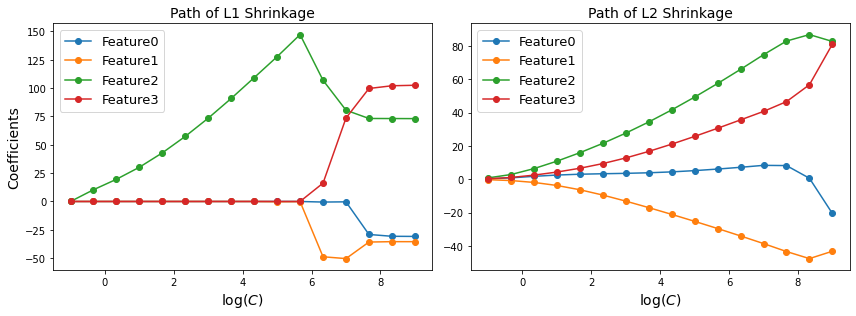

In [4]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(12, 4.5))

path_l1.T.plot(marker='o', ax=axes[0])
axes[0].set_title('Path of L1 Shrinkage', fontsize=14)
axes[0].set_xlabel(r'$\log(C)$', fontsize=14)
axes[0].set_ylabel('Coefficients', fontsize=14)
axes[0].legend(loc='upper left', fontsize=13)

path_l2.T.plot(marker='o', ax=axes[1])
axes[1].set_title('Path of L2 Shrinkage', fontsize=14)
axes[1].set_xlabel(r'$\log(C)$', fontsize=14)
axes[1].legend(loc='upper left', fontsize=13)

plt.tight_layout()
plt.show()